In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

# Create a MySQL Connection
mysql_connection = mysql.connector.connect(user='root', host='localhost', password='Mwende#2001!', database='rest_api')
if mysql_connection.is_connected():
    print("Congratulations! Connection successful.")
else:
    print("Oops! Connection unsuccessful. Please try again.")

# Loading the second dataset 
query_2 = "SELECT * FROM DIABETES_PREDICTION_DATASET;"
diabetes_data = pd.read_sql(query_2, mysql_connection)
if diabetes_data.empty:
    print('Mission incomplete.')
else:
    print('Mission successfully completed!')

# Closing the connection
mysql_connection.close()
print("Connection closed.")



Congratulations! Connection successful.


C:\Users\PC\AppData\Local\Temp\ipykernel_2308\290530685.py:23: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  diabetes_data = pd.read_sql(query_2, mysql_connection)


Mission successfully completed!
Connection closed.


## Exploratory Data Analysis

In [43]:
# Checking for missing values
print(diabetes_data.isnull().sum())

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64


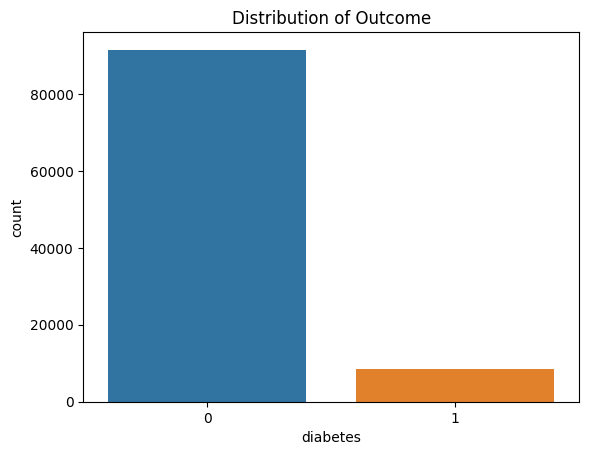

In [3]:
# Checking the distribution of the outcome variable
sns.countplot(x='diabetes', data=diabetes_data)
plt.title('Distribution of Outcome')
plt.show()

In [18]:
from sklearn.preprocessing import OneHotEncoder

# Instantiate the OneHotEncoder
encoder = OneHotEncoder(drop='first', sparse=False)

# Fit and transform the categorical columns
encoded_categorical = encoder.fit_transform(diabetes_data[['gender', 'smoking_history']])

# Retrieve the feature names from the encoder
feature_names = encoder.get_feature_names_out(['gender', 'smoking_history'])

# Create a DataFrame from the encoded categorical data
encoded_df = pd.DataFrame(encoded_categorical, columns=feature_names)

# Concatenate the encoded categorical DataFrame with the original DataFrame
diabetes_data_encoded = pd.concat([diabetes_data.drop(columns=['gender', 'smoking_history']), encoded_df], axis=1)

# Display the encoded DataFrame
diabetes_data_encoded


c:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes,gender_Male,gender_Other,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current
0,80.0,0,1,25.19,6.6,140,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,54.0,0,0,27.32,6.6,80,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,28.0,0,0,27.32,5.7,158,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,36.0,0,0,23.45,5.0,155,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,76.0,1,1,20.14,4.8,155,0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,80.0,0,0,27.32,6.2,90,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99996,2.0,0,0,17.37,6.5,100,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99997,66.0,0,0,27.83,5.7,155,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
99998,24.0,0,0,35.42,4.0,100,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## Feature Engineering

In [36]:
# Splitting the dataset into features and target variable
X = diabetes_data_encoded.drop('diabetes', axis=1)
y = diabetes_data_encoded['diabetes']

# Splitting the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [37]:
# Standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [44]:
# Reshaping the features for compatibility with Conv1D
input_shape = (X_train_scaled.shape[1], 1)  # Number of independent features

# Reshape the input data for compatibility with Conv1D
X_train_reshaped = X_train.values.reshape(-1, input_shape[0], 1)
X_test_reshaped = X_test.values.reshape(-1, input_shape[0], 1)

In [45]:
# Create the CNN model
model = Sequential([
    Conv1D(32, kernel_size=3, activation='relu', input_shape=input_shape),
    MaxPooling1D(pool_size=1),
    Conv1D(64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=1),
    Conv1D(128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=1),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Assuming binary classification (0 or 1)
])

In [46]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss=BinaryCrossentropy(),
              metrics=['accuracy'])

In [47]:
# Print model summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_9 (Conv1D)           (None, 11, 32)            128       
                                                                 
 max_pooling1d_9 (MaxPoolin  (None, 11, 32)            0         
 g1D)                                                            
                                                                 
 conv1d_10 (Conv1D)          (None, 9, 64)             6208      
                                                                 
 max_pooling1d_10 (MaxPooli  (None, 9, 64)             0         
 ng1D)                                                           
                                                                 
 conv1d_11 (Conv1D)          (None, 7, 128)            24704     
                                                                 
 max_pooling1d_11 (MaxPooli  (None, 7, 128)           

In [48]:
# Train the model
history = model.fit(X_train_reshaped, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(X_test_reshaped, y_test))

Epoch 1/10


2500/2500 [==============================] - 23s 8ms/step - loss: 0.2246 - accuracy: 0.9256 - val_loss: 0.1364 - val_accuracy: 0.9450
Epoch 2/10
2500/2500 [==============================] - 20s 8ms/step - loss: 0.1489 - accuracy: 0.9423 - val_loss: 0.1148 - val_accuracy: 0.9578
Epoch 3/10
2500/2500 [==============================] - 20s 8ms/step - loss: 0.1339 - accuracy: 0.9505 - val_loss: 0.1135 - val_accuracy: 0.9553
Epoch 4/10
2500/2500 [==============================] - 19s 8ms/step - loss: 0.1257 - accuracy: 0.9538 - val_loss: 0.1302 - val_accuracy: 0.9624
Epoch 5/10
2500/2500 [==============================] - 20s 8ms/step - loss: 0.1226 - accuracy: 0.9548 - val_loss: 0.1132 - val_accuracy: 0.9553
Epoch 6/10
2500/2500 [==============================] - 20s 8ms/step - loss: 0.1191 - accuracy: 0.9572 - val_loss: 0.1114 - val_accuracy: 0.9561
Epoch 7/10
2500/2500 [==============================] - 20s 8ms/step - loss: 0.1172 - accuracy: 0.9589 - val_loss: 0.1009 - val_

In [50]:
# Save the trained model to a 
import joblib
joblib.dump(history, 'cnn2_model.joblib')

['cnn2_model.joblib']